# Multilayer Perceptron neural network

In this project, We build the first neural network and use it to predict daily bike rental ridership. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' #Display figure and plot in retina quality

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. By pre-processing and normalize the data, we can make our objective function to roughly have a symmetric shape in the parameters. Below, we've written the code to load and prepare the data.

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)

In [39]:
rides.head();

## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. 

Each entry: on one day in a specific hour, the weather feature vector (humidity, temperature, windspeed), number of total riders, casual riders, and registered riders.

Variables:

Important Features for prediction:

* holiday: 1 if it is holiday on that day, and 0 otherwise 
* season: season index, 1 means winter, 2 means spring, 3 means summer, 4 means autumn
* mnth: month index from 1 to 12
* weekday: 0 to 6, 0 is Sunday, 1 is Monday,..., 6 is Saturday
* hr: hour index within a day, 0 refers the one hour between 0am and 1am, 23 refers to the one hour between 23pm and 0am
* workingday: indicator for whether it is working day, Monday to Friday are, and Saturday and Sunday are not.
* temp: temperature
* hum: humity index
* casual: number of casual riders in that hour
* registered: number of registered riders in that hour
* cnt: the sum of casual and registered

Other Features:

* dteday: the date
* yr: year index, 0 means the 1st year-2011, 1 means the second year-2012

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders.

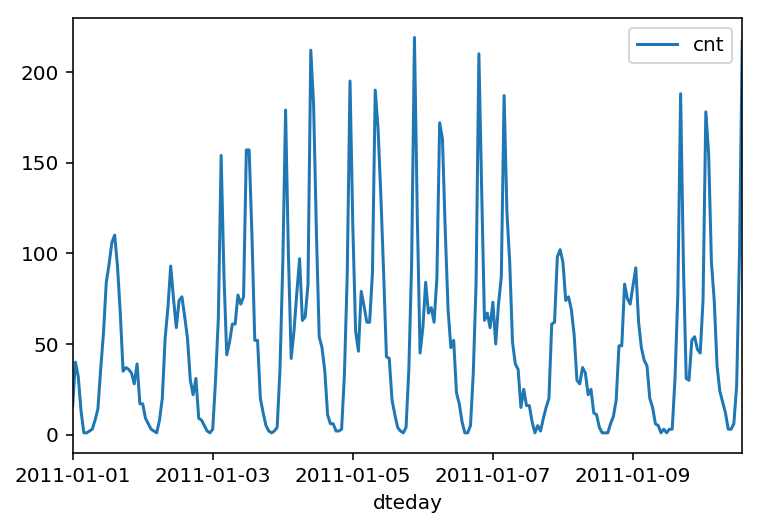

In [4]:
rides[:24*10].plot(x = 'dteday', y = 'cnt')
#rides[:24*10].plot(x = 'dteday', y = 'registered')
plt.show()

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [16]:
#pd.get_dummies converts a column of categorical variables into multiple columns
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head();

### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [9]:
batch = np.random.choice(train_features.index, size=1)
X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes. **The number of training passes (of minibatch) corresponds to the number of iterations or steps in climbing down**

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. ** So we can view each node to have a left hole and right hole, in the middle is the activation function**.

A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Note:** Given the architecture of the MLP and the training data, let the current weight be $W$ (including all the parameters), then after passing all the training examples forward under $W$, we obtain value of the loss function at $W$ (i.e. elevation); after continuing passing all of them backward, we obtain value of the gradients at $W$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [10]:
#__init__ is what is called as a constructor in other OOP (object-oriented programming) languages such as C++/Java. 
#The basic idea is that it is a special method which is automatically called when an object of that Class is created

In [11]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        #__init__ is to initialize values of some attributes for the class.
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        
        # Initialize weights: initializing is to choose where to start climbing down the hill
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # lambda expression,
        #self.activation_function = lambda x : 1/(1+np.exp(-x))  # Replace 0 with your sigmoid calculation.
        def sigmoid(x):
            return 1/(1+np.exp(-x))  # Replace 0 with your sigmoid calculation here
        self.activation_function = sigmoid
        #If I now define nn = NeuralNetwork(3,2,1,0.1), then nn is an <<object>> having 7 already defined attributes, 
        #nn.input_nodes = 3, nn.hidden_nodes = 2, nn.output_nodes = 1, and nn.weights_input_to_hidden, ...   
        #Try copy and paste above code (excluding other methods below), define one object and pull put its attributes
    
    #Below is to define method belonging to the class NeuralNetwork, if nn = NeuralNetwork(3,2,1,0.1), then we can use
    #nn.train(features,targets) where features and targets need to be pre-defined.
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
            Arguments
            --------- 
            features: 2D array (i.e. matrix), each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        #Text inside two triple string can be called by the function help(). It is called DocString
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            # In each loop, it will pull out one row in the features matrix, defined to be X, where X is a vector 
            # of shape (xxx,), needing to be reshaped into a column vector. It will also pull out the corresponding
            # element in targets and define it to be y, which is a scalar
            hidden_inputs = np.dot(self.weights_input_to_hidden.T,X.reshape(-1,1)) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs)               # signals from hidden layer

            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(self.weights_hidden_to_output.T,hidden_outputs) # signals into final output layer
            final_outputs = final_inputs # signals from final output layer
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            error = y-final_outputs # Output layer error is the difference between desired target and actual output.
            error = error[0]  # Needed to convert the shape from (1,1) to (1,) in order to put into delta_weights_h_o
            # TODO: Calculate the hidden layer's contribution to the error
            #hidden_error = None
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            #output_error_term = None
            #hidden_error_term = None 
            
           
            # Weight step (input to hidden)
            for i in range(self.weights_input_to_hidden.shape[0]):
                for j in range(self.weights_input_to_hidden.shape[1]):
                    delta_weights_i_h[i,j] += -error*self.activation_function(hidden_inputs[j])\
                    *(1-self.activation_function(hidden_inputs[j]))\
                    *self.weights_hidden_to_output[j]*X.reshape(-1,1)[i]
            
            # Weight step (hidden to output)
            for j in range(self.weights_hidden_to_output.shape[0]):
                delta_weights_h_o[j] += -error*hidden_outputs[j]

        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output -= delta_weights_h_o*self.lr/n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden -= delta_weights_i_h*self.lr/n_records # update input-to-hidden weights with gradient descent step
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(self.weights_input_to_hidden.T,features.T)      # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)               # signals from hidden layer

        # TODO: Output layer - Replace these values with your calculations.
        final_inputs = np.dot(self.weights_hidden_to_output.T,hidden_outputs) # signals into final output layer
        final_outputs = final_inputs.T # signals from final output layer
        #final_outputs is a column vector if there is one output node, and it is a matrix if there are multiple output
        #nodes, each row is the fitted values corresponding to one training example, one value for one category 
        return final_outputs

### Notes on Backpropagation
Suppose there are three layers (including one hidden layer), we focus on calculating the gradient for one training example since the total gradient is just a sum of gradients for all the training exmaples. Let the training example be $x$ with dimension $1\times n_1$, the hidden layer is of dimension $n_2\times1$, and the output is of dimension $n_3=1$. Let the activation function at the hidden layer be $f_2(\cdot)$, and that at the output layer be $f_3(\cdot)$, which in most case is the identity function. Let the two weight matrices be $W_1$ of dimension $n_1\times n_2$, $W_2$ of dimension $n_2\times n_3=n_2\times1$. The bias vectors be $b_1,b_2$, then the output is 

\begin{align*}
\widehat y = f_3\left(W_2^Tf_2(W_1^Tx^T+b_1)+b_2\right),
\end{align*}

where we applied $f_2$ in an elementwise sense. That is, if 

\begin{align*}
W_1=\left[\begin{array}{cccc}w_{1,11}&w_{1,12}&\cdots&w_{1n_2}\\
w_{1,21}&w_{1,22}&\cdots&w_{1,2n_2}\\
\vdots\\
w_{1,n_11}&w_{1,n_12}&\cdots&w_{1,n_1n_2}\end{array}\right],~
\text{then }
f_2(W_1^Tx^T+b_1)&=\left[\begin{array}{c}
f_2\left(\sum_{k=1}^{n_1}w_{1,k1}x_k+b_{11}\right)\\
f_2\left(\sum_{k=1}^{n_1}w_{1,k2}x_k+b_{12}\right)\\
\vdots\\
f_2\left(\sum_{k=1}^{n_1}w_{1,kn_2}x_k+b_{1n_2}\right)\end{array}\right]
=\left[\begin{array}{cc}
f_2\left(W_{1,\cdot1}^Tx^T+b_{11}\right)\\
f_2\left(W_{1,\cdot2}^Tx^T+b_{12}\right)\\
\vdots\\
f_2\left(W_{1,\cdot n_2}^Tx^T+b_{1n_2}\right)\end{array}\right],
\end{align*}

where $W_{1,\cdot j}$ represents the $j$-th column of $W_1$.

The squared error for this training example is

\begin{align*}
e\equiv e(W_1,W_2,b_1,b_2)=\frac{1}{2}(y-\widehat y)^2.
\end{align*}

Now propagating backward, first, its derivative function wrt $W_2$ is

\begin{align*}
\frac{\partial e}{\partial W_2}&\equiv \frac{\partial e}{\partial W_2}(W_1,W_2,b_1,b_2,y,x)
=-(y-\widehat y)\frac{\partial\widehat y}{\partial W_2},
\end{align*}

where

\begin{align*}
\frac{\partial\widehat y}{\partial W_2}&=f_3^\prime\left(W_2^Tf_2(W_1^Tx^T+b_1)+b_2\right)\left[\begin{array}{cccc}f_{21}&f_{22}&\cdots&f_{2n_2}\end{array}\right]
=f_3^\prime\left(W_2^Tf_2(W_1^Tx^T+b_1)+b_2\right)f^T_2(W_1^Tx^T+b_1),
\end{align*}

and $f_{2j}$ is the $j$-th element of $f_2(W_1^Tx^T+b_1)$. Also,

\begin{align*}
\frac{\partial e}{\partial b_2}&\equiv \frac{\partial e}{\partial b_2}(W_1,W_2,b_1,b_2,y,x)=-(y-\widehat y).
\end{align*}

Second, its derivative wrt $W_1$ is

\begin{align*}
\frac{\partial e}{\partial W_1}&\equiv \frac{\partial e}{\partial W_1}(W_1,W_2,b_1,b_2,y,x)=-(y-\widehat y)\frac{\partial\widehat y}{\partial W_1},
\end{align*}

where $\frac{\partial\widehat y}{\partial W_1}=\frac{\partial\widehat y}{\partial W_1}(W_1,W_2,b_1,b_2,x,y)$ is a matrix of the same dimension as $W_1$, with its $(i,j)$-th element to be 

\begin{align*}
\left[\frac{\partial\widehat y}{\partial W_1}\right]_{ij}&=f_3^\prime\left(W_2^Tf_2(W_1^Tx^T+b_1)+b_2\right)f^\prime_2\left(\sum_{k=1}^{n_1}w_{1,kj}x_k+b_{1j}\right)W_2^T\left[\begin{array}{c}0\\\vdots\\x_i\\\vdots\\0\end{array}\right]\\
&=f_3^\prime\left(W_2^Tf_2(W_1^Tx^T+b_1)+b_2\right)f^\prime_2\left(W_{1,\cdot j}^Tx^T+b_{1j}\right)W_2^T\left[\begin{array}{c}0\\\vdots\\x_i\\\vdots\\0\end{array}\right]
\end{align*}

where the above sparse vector is of dimension $n_2\times1$, and its $j$-th element is $x_i$ (i.e., the $i$-th component of $x$). This above result is obtained by doing the partial derivative element by element. Also,

\begin{align*}
\frac{\partial e}{\partial b_1}&\equiv \frac{\partial e}{\partial b_1}(W_1,W_2,b_1,b_2,y,x)=-(y-\widehat y)\frac{\partial\widehat y}{\partial b_1},
\end{align*}

where $\frac{\partial\widehat y}{\partial b_1}$ is a vector of dimension $n_2\times1$, and its $j$-th element is

\begin{align*}
\left[\frac{\partial\widehat y}{\partial b_1}\right]_j=f_3^\prime\left(W_2^Tf_2(W_1^Tx^T+b_1)+b_2\right)f^\prime_2\left(W_{1,\cdot j}^Tx^T+b_{1j}\right)W_2^Te_j^T,
\end{align*}

where $e_j=(0,\cdots,1,\cdots,0)$ is the canonical vector in $R^{n_2}$, with its $j$-th element to be $1$.

The above is the full expression. Now to simplify notation in order to prepare for the implementation, let $I^{(l)}_j,a^{(l)}_j$ be the $j$-th input and $j$-th activation at layer $l$. That is, $a_j^{(l)}=f_l(I^{(l)}_j)$, where $f_j(\cdot)$ is the activation function at layer $l$. Now we can simply write

\begin{align*}
\left[\frac{\partial e}{\partial W_2}\right]_j&=-(y-\widehat y)f_3^\prime(I_1^{(3)})a_j^{(2)},~
\frac{\partial e}{\partial b_2}=-(y-\widehat y)\\
\left[\frac{\partial e}{\partial W_1}\right]_{ij}&=-(y-\widehat y)f_3^\prime(I_1^{(3)})f_2^\prime(I_j^{(2)})W_{2,j}x_i,~
\left[\frac{\partial e}{\partial b_1}\right]_{j}=-(y-\widehat y)f_3^\prime(I_1^{(3)})f_2^\prime(I_j^{(2)})W_{2,j},
\end{align*}

where $W_{2,j}$ is the $j$-th element of $W_2$ since $W_2$ is only of dimension $n_2\times1$, and $I_{1}^{(3)}$ is the only input of the output layer which has one node. In the implementation, keep in mind that $f_3^\prime(t)=1$. Also, in the simplified implementation below, we do not consider the bias terms and set them to be 0.

In [12]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [13]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.032s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, if you use too many iterations, then the model with not generalize well to other data, this is called overfitting. You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. As you start overfitting, you'll see the training loss continue to decrease while the validation loss starts to increase.

### Choose the learning rate
It determines the step size in weight updates. Too big a value can make the network fails converge. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. A lower learning rate corresponds to smaller steps and it takes longer for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [ ]:
import sys  # Loading sys library so that we can use functions such as sys.stdout.write() and sys.stdout.flush()

### Set the hyperparameters here ###
iterations = 200
input_nodes = train_features.shape[1]
hidden_nodes = 10
output_nodes = 1
learning_rate = 0.1

network = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y) # The output of this procedure is updated weights
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features), train_targets['cnt'].values.reshape(-1,1))
    val_loss = MSE(network.run(val_features), val_targets['cnt'].values.reshape(-1,1))
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 36.5% ... Training loss: 0.684 ... Validation loss: 1.123

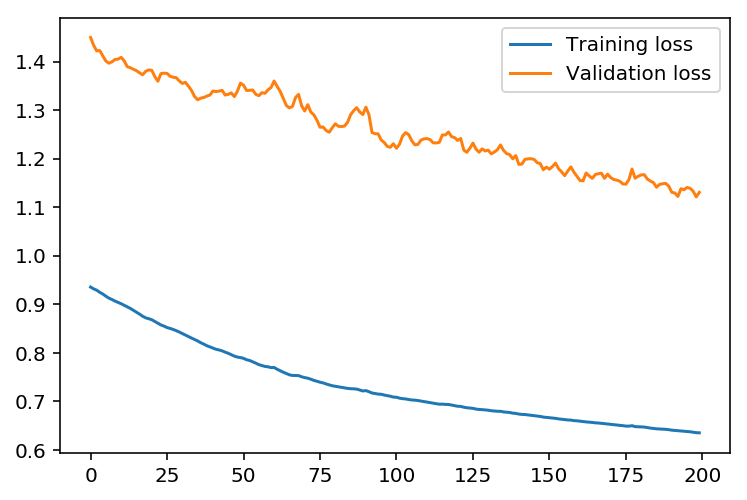

In [40]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

In [41]:
#Calculating the Testing Error
mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
test_error = MSE(predictions,((test_targets['cnt']*std + mean).values).reshape(-1,1))
test_error

17382.653765582108

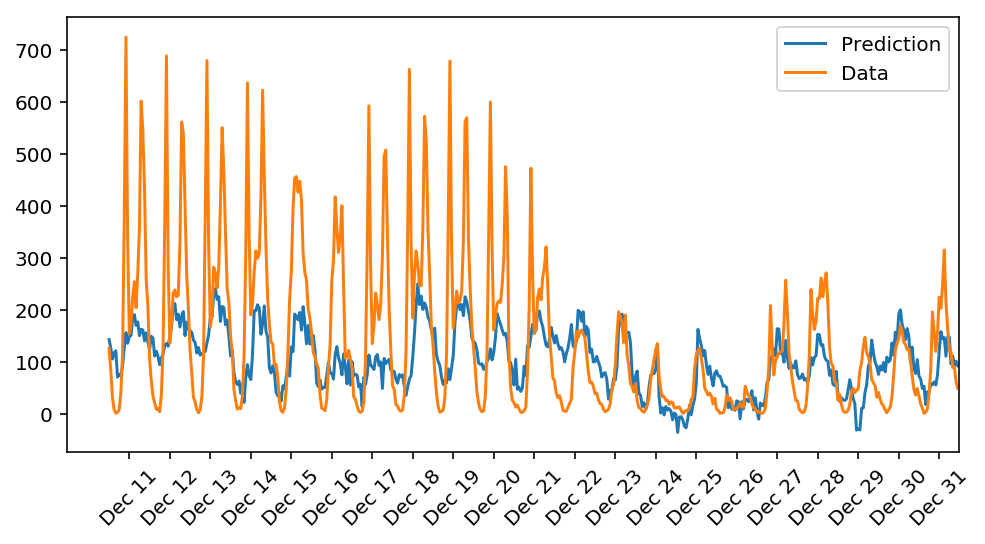

In [37]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(predictions, label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below